**GOALS**:
- Get tracking information.
- Understand why the MLflow ui does not show all runs...
- Prepare some plotting and choose the final model.

**Table of contents**<a id='toc0_'></a>    
- 1. [First test results](#toc1_)    
- 2. [Results for all models on all features (50 hyperopt evals per model)](#toc2_)    
- 3. [Get the best model params](#toc3_)    
- 4. [Fit the random forest classifier with optional smote, optional ohe and observe results](#toc4_)    
- 5. [Understanding SHAP values and feature importance](#toc5_)    
  - 5.1. [Fit the model and predict on the test set and evaluate.](#toc5_1_)    
- 6. [Tag best runs in experiments.](#toc6_)    
- 7. [Explore results of scaling and imputation variations](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
from project_tools import utils
import pandas as pd
import matplotlib.pyplot as plt

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>First test results

In [19]:
exp_name = 'all_features_minmax_knn'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=False)

In [20]:
results.parent_run_name.value_counts()

parent_run_name
Lasso-type Logistic Regression    100
Random Forest                      50
Rigde-type Logistic Regression     50
Name: count, dtype: int64

In [21]:
results.shape

(204, 45)

The UI did not show lasso-type logistic regressions tracking, so I launched it a second time.

I see the 3 models with one being tuned 2 times (so $50\times4 + 4 parentruns$).

Now, it does not show ridge-type anymore...

In [22]:
results.isnull().mean()

experiment_id                                       0.000000
status                                              0.000000
artifact_uri                                        0.000000
start_time                                          0.000000
end_time                                            0.000000
metrics.test_loss_of_income                         0.019608
metrics.CV_recall_specificity_G_mean                0.019608
metrics.test_threshold_AUC                          0.019608
metrics.CV_AUC                                      0.019608
metrics.test_f2                                     0.019608
metrics.test_threshold_f2                           0.019608
metrics.test_threshold_loss_of_income               0.019608
metrics.test_AUC                                    0.019608
metrics.CV_threshold_f2                             0.019608
metrics.test_recall_specificity_G_mean              0.019608
metrics.CV_threshold_loss_of_income                 0.019608
metrics.CV_loss_of_incom

In [23]:
results.status.value_counts()

status
FINISHED    204
Name: count, dtype: int64

In [30]:
results.columns

Index(['experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time',
       'metrics.test_loss_of_income', 'metrics.CV_recall_specificity_G_mean',
       'metrics.test_threshold_AUC', 'metrics.CV_AUC', 'metrics.test_f2',
       'metrics.test_threshold_f2', 'metrics.test_threshold_loss_of_income',
       'metrics.test_AUC', 'metrics.CV_threshold_f2',
       'metrics.test_recall_specificity_G_mean',
       'metrics.CV_threshold_loss_of_income', 'metrics.CV_loss_of_income',
       'metrics.CV_f2', 'metrics.CV_threshold_recall_specificity_G_mean',
       'metrics.CV_threshold_AUC',
       'metrics.test_threshold_recall_specificity_G_mean',
       'params.class_weight', 'params.solver', 'params.C',
       'params.min_samples_leaf', 'params.max_depth', 'params.criterion',
       'params.min_samples_split', 'params.n_estimators', 'tags.optimizer',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.stratified_cv', 'tags.mlflow.runName', 'tags.mlflow.parentRunId',


In [31]:
results[['params.class_weight', 'params.solver', 'params.C']].head()

,params.class_weight,params.solver,params.C
run_id,,,
b54203793634400cbf49895bd579fc60,None,liblinear,0.31423484282449005
760cf457afda4a1db47888a181919e65,None,liblinear,0.30076560914413636
cd67b1a2350e4b939231bb2714c0a5d8,None,liblinear,0.2965396244206103
91bb0657a20d44fd825dbbfa861a00ce,None,liblinear,0.18545765719736262
7d2561e58d6945f58f2533194395699b,None,liblinear,0.17929562035794164


In [24]:
results2 = utils.get_runs_information(exp_id, light_version=True)

In [26]:
results2.head(50)

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
b54203793634400cbf49895bd579fc60,0.709632,469.0,0.460277,0.661836,144.0,0.394737,4.919,Lasso-type Logistic Regression
760cf457afda4a1db47888a181919e65,0.709632,470.0,0.460277,0.662167,145.0,0.395570,4.425,Lasso-type Logistic Regression
cd67b1a2350e4b939231bb2714c0a5d8,0.710655,473.0,0.462025,0.660804,145.0,0.394737,3.973,Lasso-type Logistic Regression
91bb0657a20d44fd825dbbfa861a00ce,0.711276,474.0,0.461165,0.681405,144.0,0.414013,5.134,Lasso-type Logistic Regression
7d2561e58d6945f58f2533194395699b,0.716031,474.0,0.468370,0.680043,144.0,0.412698,4.816,Lasso-type Logistic Regression
8249de61b3be4983b77f2b77ca985746,0.713562,474.0,0.461802,0.680043,144.0,0.412698,4.398,Lasso-type Logistic Regression
6359247ac5a9456587ca903804693f1a,0.715008,474.0,0.466667,0.680043,144.0,0.412698,5.112,Lasso-type Logistic Regression
6df8d1cbd18e4f38a0b48c4f45ccb059,0.711338,474.0,0.463198,0.670176,148.0,0.402685,4.840,Lasso-type Logistic Regression
77fe5e6ec2114f6a9a412c31df207cad,0.712020,475.0,0.464377,0.672901,148.0,0.405405,4.856,Lasso-type Logistic Regression


In [28]:
results3 = utils.get_runs_information(exp_id, light_version=True, metric_prefix='test_')
results3.head(30)


,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
24ca84d580e3461fbdff359b7505d83b,0.743891,518.0,0.493519,0.708529,116.0,0.459459,29.880,Random Forest
98bdf548d5e4403697aa03bb1a33bc35,0.724171,502.0,0.470041,0.707167,117.0,0.456989,12.663,Random Forest
5fce8317045a49598854bfa0b638bd9a,0.720582,505.0,0.470035,0.685204,118.0,0.421053,22.044,Random Forest
bc2937ea577f4d5da031f9515b31bbb8,0.735283,491.0,0.484721,0.697795,120.0,0.439024,34.902,Random Forest
490ad6cbc5544042ac85f9a0f6a9b45f,0.724451,506.0,0.467005,0.695360,120.0,0.437158,32.568,Random Forest
57a4d82307554b46b6cdcf2950e4059a,0.725296,507.0,0.472973,0.689621,121.0,0.426540,25.203,Random Forest
ba2cb5304ae14ee09a671d2cc0a21ab6,0.730753,505.0,0.480973,0.675336,122.0,0.404624,28.683,Random Forest
9b4775e2d5a34b23b1de1d9d42981200,0.736291,490.0,0.493197,0.675336,122.0,0.407407,33.386,Random Forest
295d14c2a9d24d5eb7fd211b3901b313,0.742868,501.0,0.492048,0.687722,123.0,0.421245,18.151,Random Forest


# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Results for all models on all features (50 hyperopt evals per model)

To be fair, 50 max_evals is probably not enough to find a decent hyperparameter setup 
for XGBoost and LightGBM which have many hyperparameters to tune. 

Nevertheless, now that my procedure for exploring models varying pre-processing is ready and implemented as an MLproject, it would be easy to scale it and run a systematic search with some more computational power to get professional results. 

Though, I will not do it because many steps of the project are still on schedule.

In [2]:
exp_name = 'all_fts_minmax_knn'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=True)

In [8]:
results.head(50)

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
d8e0a324bfb94fc3bbfedf9c4d4360be,0.741748,0.290625,0.502994,0.670217,0.3200,0.398010,24.896,Random Forest
8732eae2be37434bb47447f0525dc63b,0.739778,0.291250,0.486855,0.682933,0.3150,0.415385,22.811,Random Forest
ea8d66f46e0f43709e647163f1ac73aa,0.709973,0.294375,0.460859,0.668813,0.3675,0.401338,4.123,Lasso-type Logistic Regression
126a09ec6b1c42c0b6f5484361feca6b,0.711679,0.295625,0.463787,0.672529,0.3700,0.406504,4.127,Lasso-type Logistic Regression
7ea45a4e57df49ffa98356522929c323,0.709632,0.295625,0.460277,0.670176,0.3675,0.402685,3.634,Lasso-type Logistic Regression
4572bea7814645cdaac2d46659cb0570,0.710411,0.295625,0.459492,0.669144,0.3750,0.402477,3.714,Lasso-type Logistic Regression
73584fdb25744214bf5a5a8dcc2789db,0.709291,0.296250,0.459698,0.668813,0.3675,0.401338,4.340,Lasso-type Logistic Regression
ae1caf1d42d84762b80e478a60983a86,0.709408,0.296250,0.459698,0.670176,0.3675,0.402685,4.336,Lasso-type Logistic Regression
e43dd70c864c4698ae87fe6838fb6e81,0.709632,0.296250,0.460277,0.653167,0.3650,0.389972,4.104,Lasso-type Logistic Regression


In [24]:
scorers = utils.my_Scorers

AUC
top-15:


,run_id,metrics.CV_AUC,metrics.test_AUC,fit_time_s,parent_run_name
75,4090ba0636d64443a10f1b27ab8fbf0e,0.747704,0.667988,8.044,LightGBM Classifier
102,583c45e0c3d0433eb32cc6c50beff236,0.746457,0.679052,38.040,Random Forest
81,501752272e5a4ebdb5b91a1d5e97caee,0.743891,0.684502,37.901,Random Forest
0,d8e0a324bfb94fc3bbfedf9c4d4360be,0.741748,0.670217,24.896,Random Forest
76,5a421afb372b4f26919e0f0b1c5b7f47,0.740180,0.689291,22.100,Random Forest
1,8732eae2be37434bb47447f0525dc63b,0.739778,0.682933,22.811,Random Forest
64,97f8ceb4f7a740e5afab268c1f61ea69,0.739320,0.677855,8.257,LightGBM Classifier
112,e5225a720d2e4c1cb99c4405423b16fe,0.739239,0.672529,15.087,Random Forest
194,44a9bab20b94401583213e2c9bd6a7eb,0.737951,0.641937,26.418,SVC_rbf
39,544e7082658f4c5ea17f34f5a4b36ba6,0.736607,0.673768,23.998,Random Forest



best tuning for each model type:


,run_id,metrics.CV_AUC,metrics.test_AUC,fit_time_s
parent_run_name,,,,
Lasso-type Logistic Regression,260d4384e29a4c51a1388bfbda2af2f7,0.727485,0.657378,3.461
LightGBM Classifier,4090ba0636d64443a10f1b27ab8fbf0e,0.747704,0.667988,8.044
Random Forest,583c45e0c3d0433eb32cc6c50beff236,0.746457,0.679052,38.040
Rigde-type Logistic Regression,16f5251ee53e44d6bf26cf06e4e1a805,0.726278,0.671703,3.987
SVC_poly,e3288730c4e74207aa356f88bad20d0a,0.728320,0.624391,14.109
SVC_rbf,44a9bab20b94401583213e2c9bd6a7eb,0.737951,0.641937,26.418
XGBoost Classifier,05cc3d3e3bca472fb55c157fe71ff295,0.726461,0.672240,27.288


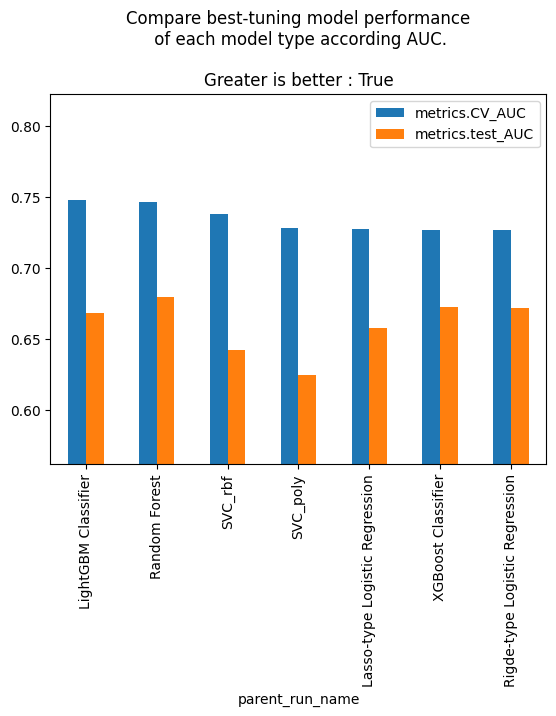

f2
top-15:


,run_id,metrics.CV_f2,metrics.test_f2,fit_time_s,parent_run_name
0,d8e0a324bfb94fc3bbfedf9c4d4360be,0.502994,0.398010,24.896,Random Forest
75,4090ba0636d64443a10f1b27ab8fbf0e,0.502092,0.397490,8.044,LightGBM Classifier
64,97f8ceb4f7a740e5afab268c1f61ea69,0.496098,0.410156,8.257,LightGBM Classifier
81,501752272e5a4ebdb5b91a1d5e97caee,0.493519,0.418410,37.901,Random Forest
38,293f72ac0fbb44a98e55950c3c7bd52c,0.492468,0.401460,7.896,LightGBM Classifier
112,e5225a720d2e4c1cb99c4405423b16fe,0.492063,0.406504,15.087,Random Forest
104,e8459dda04ff4e748fbee62f386fedd5,0.490731,0.384615,8.430,LightGBM Classifier
102,583c45e0c3d0433eb32cc6c50beff236,0.490376,0.411523,38.040,Random Forest
76,5a421afb372b4f26919e0f0b1c5b7f47,0.489899,0.427807,22.100,Random Forest
97,84ed62e9b6d0461195bf5fb2705ced81,0.487541,0.413223,10.732,LightGBM Classifier



best tuning for each model type:


,run_id,metrics.CV_f2,metrics.test_f2,fit_time_s
parent_run_name,,,,
Lasso-type Logistic Regression,260d4384e29a4c51a1388bfbda2af2f7,0.481651,0.394022,3.461
LightGBM Classifier,4090ba0636d64443a10f1b27ab8fbf0e,0.502092,0.397490,8.044
Random Forest,d8e0a324bfb94fc3bbfedf9c4d4360be,0.502994,0.398010,24.896
Rigde-type Logistic Regression,d1a9a4bf2fae476c8b5e3451677aa8d5,0.473204,0.394022,4.450
SVC_poly,e3288730c4e74207aa356f88bad20d0a,0.466102,0.351906,14.109
SVC_rbf,44a9bab20b94401583213e2c9bd6a7eb,0.480072,0.371622,26.418
XGBoost Classifier,05cc3d3e3bca472fb55c157fe71ff295,0.480000,0.403226,27.288


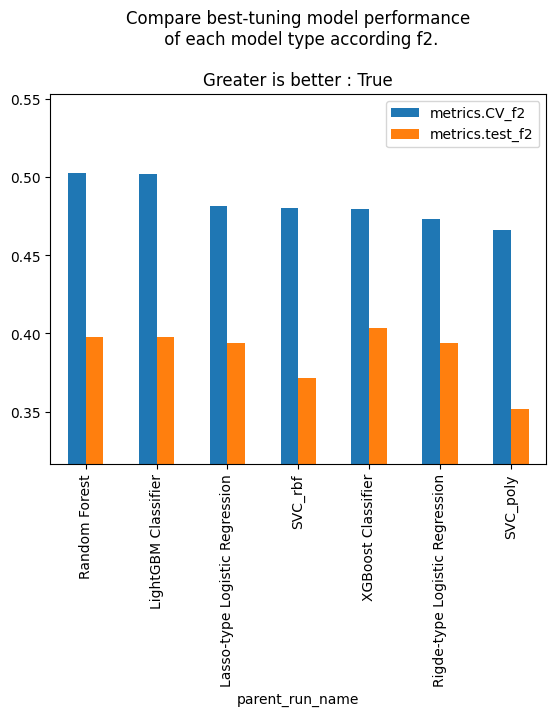

loss_of_income
top-15:


,run_id,metrics.CV_loss_of_income,metrics.test_loss_of_income,fit_time_s,parent_run_name
0,d8e0a324bfb94fc3bbfedf9c4d4360be,0.290625,0.3200,24.896,Random Forest
1,8732eae2be37434bb47447f0525dc63b,0.291250,0.3150,22.811,Random Forest
2,ea8d66f46e0f43709e647163f1ac73aa,0.294375,0.3675,4.123,Lasso-type Logistic Regression
3,126a09ec6b1c42c0b6f5484361feca6b,0.295625,0.3700,4.127,Lasso-type Logistic Regression
4,7ea45a4e57df49ffa98356522929c323,0.295625,0.3675,3.634,Lasso-type Logistic Regression
5,4572bea7814645cdaac2d46659cb0570,0.295625,0.3750,3.714,Lasso-type Logistic Regression
6,73584fdb25744214bf5a5a8dcc2789db,0.296250,0.3675,4.340,Lasso-type Logistic Regression
7,ae1caf1d42d84762b80e478a60983a86,0.296250,0.3675,4.336,Lasso-type Logistic Regression
8,e43dd70c864c4698ae87fe6838fb6e81,0.296250,0.3650,4.104,Lasso-type Logistic Regression
10,e921ec606fbc41caaed819b2ec8561fa,0.296875,0.3600,4.451,Lasso-type Logistic Regression



best tuning for each model type:


,run_id,metrics.CV_loss_of_income,metrics.test_loss_of_income,fit_time_s
parent_run_name,,,,
Lasso-type Logistic Regression,ea8d66f46e0f43709e647163f1ac73aa,0.294375,0.3675,4.123
LightGBM Classifier,293f72ac0fbb44a98e55950c3c7bd52c,0.304375,0.3475,7.896
Random Forest,d8e0a324bfb94fc3bbfedf9c4d4360be,0.290625,0.3200,24.896
Rigde-type Logistic Regression,131da8d8245b42ef87fe890a9728bf1d,0.301875,0.3575,5.145
SVC_poly,ff73ce5216cb452f8d47bde5d3b051cd,0.342500,0.3750,14.738
SVC_rbf,12b4802eebb84382ac5d6db9ab694b6e,0.330625,0.3675,24.900
XGBoost Classifier,705f72b891ea41e6aaf6fcd5d369ae6c,0.302500,0.3450,360.156


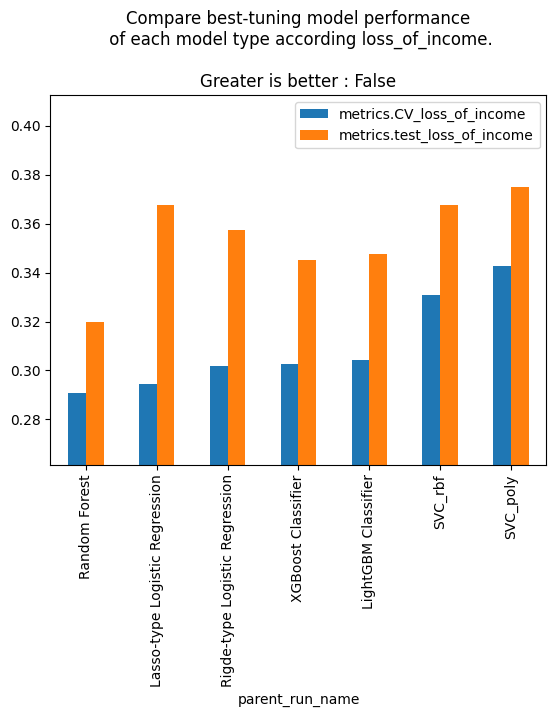

In [51]:
metrics = ['loss_of_income', 'AUC', 'f2']

for scorer_name, scorer in scorers.items():
    if scorer_name in metrics:
        print(scorer_name)
        cols = [col for col in results.columns if scorer_name in col]
        cols.append('fit_time_s')
        cols.append('parent_run_name')
        
        # Sort so the best models (regarding the score on CV) 
        # are in head().
        CV_metric_name = f'metrics.CV_{scorer_name}'
        results_per_metric = (
            results
            .loc[:, cols]
            .reset_index()
            .sort_values(
                CV_metric_name, 
                ascending=(not scorer.greater_is_better)
            )
        )
        
        print('top-15:')
        display(results_per_metric.head(10))
        # Get info on the best model of each model type.       
        best_tuning = (
            results_per_metric
            .groupby('parent_run_name')
            .first()
        )
        print('\nbest tuning for each model type:')
        display(best_tuning)
        
        # Focus on best metrics to print best performance per model type
        best_metrics = (
            best_tuning
            .sort_values(
                CV_metric_name,
                ascending=(not scorer.greater_is_better)
            ).iloc[:, -3:-1]
        )
        
        min_ = best_metrics.min().min()*0.9
        max_ = best_metrics.max().max()*1.1
        best_metrics.plot(
            kind='bar',
            title=(
                f'Compare best-tuning model performance\n '
                f'of each model type according {scorer.name}.\n'
                f'\nGreater is better : {scorer.greater_is_better}'
            )
        )
        ax = plt.gca()
        ax.set(ylim=(min_, max_))
        plt.show()        

As stated before, it is possible that not enough eval rounds where made to meet a decent hyperparameter configuration for gradient boosted algorithms. As the random forest is a top scorer in all three evaluation metrics. It is the model I am going to fine tune. 

So, from now on, I want to:
- get the best hyperparameters.
- evaluate if SMOTE can improve results or not.
- explore the feature importance of some version of this model in order to perform feature selection as it might improve results and facilitate model interpretability.

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Get the best model params

In [2]:
# run_id that gave both best f2 and loss_of_income scores
best_run_id = 'd8e0a324bfb94fc3bbfedf9c4d4360be'

exp_name = 'all_fts_minmax_knn'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=False)


In [3]:
best_run = (
    results
    .loc[best_run_id, :]
)

In [4]:
best_run.head()

experiment_id                                   106582075601973595
status                                                    FINISHED
artifact_uri     file:///home/louberehc/OCR/projets/7_scoring_m...
start_time                        2023-08-26 15:08:55.414000+00:00
end_time                          2023-08-26 15:09:20.310000+00:00
Name: d8e0a324bfb94fc3bbfedf9c4d4360be, dtype: object

In [5]:
display(best_run.index)

Index(['experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time',
       'metrics.CV_threshold_recall_specificity_G_mean',
       'metrics.test_threshold_loss_of_income', 'metrics.test_f2',
       'metrics.test_loss_of_income', 'metrics.CV_threshold_f2',
       'metrics.test_recall_specificity_G_mean', 'metrics.test_threshold_f2',
       'metrics.test_threshold_AUC', 'metrics.CV_f2',
       'metrics.CV_threshold_loss_of_income', 'metrics.CV_AUC',
       'metrics.CV_recall_specificity_G_mean',
       'metrics.test_threshold_recall_specificity_G_mean',
       'metrics.CV_threshold_AUC', 'metrics.CV_loss_of_income',
       'metrics.test_AUC', 'params.gamma', 'params.max_depth',
       'params.grow_policy', 'params.min_child_weight', 'params.subsample',
       'params.colsample_bytree', 'params.scale_pos_weight', 'params.booster',
       'params.learning_rate', 'params.reg_alpha', 'params.min_split_gain',
       'params.subsample_for_bin', 'params.min_child_samples',
       'para

In [6]:
rf_params = [
    'n_estimators',
    'max_depth',
    'min_samples_leaf',
    'min_samples_split',
    'criterion',
    'class_weight',
]

params = [f"params.{param}" for param in rf_params]
params

['params.n_estimators',
 'params.max_depth',
 'params.min_samples_leaf',
 'params.min_samples_split',
 'params.criterion',
 'params.class_weight']

In [7]:
best_params = best_run.loc[params]
best_params

params.n_estimators              209
params.max_depth                  15
params.min_samples_leaf            2
params.min_samples_split           5
params.criterion            log_loss
params.class_weight             None
Name: d8e0a324bfb94fc3bbfedf9c4d4360be, dtype: object

In [8]:
best_params = best_params\
    .reset_index()\
        .rename(columns={
            'index': 'param_name',
            'd8e0a324bfb94fc3bbfedf9c4d4360be': 'values',
            }
        )

In [9]:
best_params

,param_name,values
0,params.n_estimators,209
1,params.max_depth,15
2,params.min_samples_leaf,2
3,params.min_samples_split,5
4,params.criterion,log_loss
5,params.class_weight,None


In [10]:
best_params['param_name'] = (
    best_params.param_name
    .str.split('.', expand=True)
    .iloc[:, -1]
    .to_dict()
)

In [11]:
best_params = best_params.set_index('param_name').to_dict()['values']
best_params

{'n_estimators': '209',
 'max_depth': '15',
 'min_samples_leaf': '2',
 'min_samples_split': '5',
 'criterion': 'log_loss',
 'class_weight': 'None'}

Let's note that 5 for min_samples_split was the upper bound of our hyperparameters
research. So I should explore higher values for this parameter.

I also want to observe if parameters of best performing random forest classifier are quite close.

In [14]:
results.columns

Index(['experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time',
       'metrics.CV_threshold_recall_specificity_G_mean',
       'metrics.test_threshold_loss_of_income', 'metrics.test_f2',
       'metrics.test_loss_of_income', 'metrics.CV_threshold_f2',
       'metrics.test_recall_specificity_G_mean', 'metrics.test_threshold_f2',
       'metrics.test_threshold_AUC', 'metrics.CV_f2',
       'metrics.CV_threshold_loss_of_income', 'metrics.CV_AUC',
       'metrics.CV_recall_specificity_G_mean',
       'metrics.test_threshold_recall_specificity_G_mean',
       'metrics.CV_threshold_AUC', 'metrics.CV_loss_of_income',
       'metrics.test_AUC', 'params.gamma', 'params.max_depth',
       'params.grow_policy', 'params.min_child_weight', 'params.subsample',
       'params.colsample_bytree', 'params.scale_pos_weight', 'params.booster',
       'params.learning_rate', 'params.reg_alpha', 'params.min_split_gain',
       'params.subsample_for_bin', 'params.min_child_samples',
       'para

In [18]:
rf_results = results.query('parent_run_name == "Random Forest"')
col_sel = [
    'params.n_estimators',
    'params.max_depth',
    'params.min_samples_leaf',
    'params.min_samples_split',
    'params.criterion',
    'params.class_weight',
    'metrics.CV_AUC',
    'metrics.CV_loss_of_income',
    'metrics.CV_f2',
    'metrics.test_AUC',
    'metrics.test_loss_of_income',
    'metrics.test_f2',
]
rf_results[col_sel].head(20)

,params.n_estimators,params.max_depth,params.min_samples_leaf,params.min_samples_split,params.criterion,params.class_weight,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2
run_id,,,,,,,,,,,,
d8e0a324bfb94fc3bbfedf9c4d4360be,209,15,2,5,log_loss,None,0.741748,0.290625,0.502994,0.670217,0.3200,0.398010
8732eae2be37434bb47447f0525dc63b,194,15,5,4,entropy,None,0.739778,0.291250,0.486855,0.682933,0.3150,0.415385
3879a10b7dd0471bba12b7aef29d5b72,102,14,1,4,entropy,None,0.726197,0.300625,0.470417,0.680249,0.3025,0.413043
544e7082658f4c5ea17f34f5a4b36ba6,148,14,1,4,entropy,None,0.736607,0.305000,0.479015,0.673768,0.3075,0.405405
c5d0372284f841fba457f4ac94906d2f,169,18,2,2,entropy,balanced,0.723209,0.305000,0.468750,0.676864,0.3175,0.407609
3420efc9b7cb42ae947ebb16e8cdda28,65,10,1,4,log_loss,None,0.723672,0.306250,0.473341,0.663240,0.3125,0.386598
c038a7e497094f12a4b70981b23af533,244,15,3,5,log_loss,None,0.732254,0.307500,0.475966,0.672612,0.3100,0.401662
2c33ba2f3d844ec89ad5596c29abaad8,230,17,2,3,log_loss,balanced,0.735808,0.308750,0.486039,0.696887,0.3175,0.427729
ce09f144da064e7eb8131d52fd3a19cf,209,12,3,3,gini,balanced,0.718571,0.308750,0.457778,0.688713,0.3150,0.420290


# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Fit the random forest classifier with optional smote, optional ohe and observe results

This was made in the './random_forest' MLproject. Let's get the results here.

In [2]:
exp_name = 'random_forest'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(
    exp_id=exp_id,
    light_version=True
)

In [3]:
# because results are already sorted by CV_loss_of_income
results.groupby('parent_run_name').first()

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s
parent_run_name,,,,,,,
SMOTE pipeline with Random Forest,0.723628,0.300000,0.466667,0.671954,0.363333,0.414938,11225.365
"SMOTE pipeline, ohe categorical, with Random Forest",0.727545,0.299167,0.482456,0.719540,0.360000,0.464602,4903.559
ohe categorical with Random Forest,0.736479,0.283333,0.494327,0.686272,0.356667,0.428571,4454.618


It is better to fit the model directly, without resampling.
Let's observe the best hyperparameter configurations : 

In [8]:
col_sel = [
    'params.rfc__n_estimators',
    'params.rfc__max_depth',
    'params.rfc__min_samples_leaf',
    'params.rfc__min_samples_split',
    'params.rfc__criterion',
    'params.rfc__class_weight',
    'metrics.CV_AUC',
    'metrics.CV_loss_of_income',
    'metrics.CV_f2',
    'metrics.test_AUC',
    'metrics.test_loss_of_income',
    'metrics.test_f2',
]

results = utils.get_runs_information(exp_id, light_version=False)
results[col_sel].head()

,params.rfc__n_estimators,params.rfc__max_depth,params.rfc__min_samples_leaf,params.rfc__min_samples_split,params.rfc__criterion,params.rfc__class_weight,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2
run_id,,,,,,,,,,,,
80a38ac7082c4090a43242aa50698ec7,177,17,4,5,log_loss,None,0.736479,0.283333,0.494327,0.686272,0.356667,0.428571
c0b3e1d5da004c1a81467bd4bc048258,242,14,1,4,log_loss,None,0.737913,0.284167,0.504808,0.686272,0.363333,0.428571
74a8ddd101ed4951ac616bb465f01d65,136,18,4,6,entropy,None,0.723190,0.284167,0.481833,0.672656,0.356667,0.412371
32380cb01aed45ff9b92ff1b9d1a3aa0,214,16,1,4,log_loss,None,0.733744,0.284167,0.492360,0.688097,0.353333,0.431034
37d675c02e4143739b3d677b7f7fa5cd,178,17,4,6,log_loss,None,0.735952,0.285000,0.504132,0.699045,0.346667,0.446429


log_loss as splitting criterion and not weighing classes consistently give the best results.

The other parameters could be still fine-tuned on a larger dataset.

I could go ahead evaluate how the classifier behaves if I change the scaling and the imputation method but for this project, I am moving forward and I will fit the model on a small and a larger dataset in order to determine most important features and see if it changes a lot or not.

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Understanding SHAP values and feature importance

## 5.1.  [&#9650;](#toc0_) <a id='toc5_1_'></a>Fit the model and predict on the test set and evaluate.

In [2]:
import os
MAIN_DIR = "/home/louberehc/OCR/projets/7_scoring_model"
DATA_PATH = os.path.join(MAIN_DIR, 'pickle_files/features.pkl.gz')

pre_processing_params = dict(
    predictors=None, 
    n_sample=3_000,
    ohe=True,
    clip=True,
    scaling_method='minmax',
    imputation_method='knn',
)

print('>>>>>> Load and pre-process raw features <<<<<<\n')
(
    X_train_pp, X_test_pp, y_train, y_test, pre_processors,
    
) = utils.load_split_clip_scale_and_impute_data(
    DATA_PATH,
    **pre_processing_params
)

>>>>>> Load and pre-process raw features <<<<<<

>>> Read the pickle file
It took 8.080s
>>> Filtering individual with more than 400 null values
before : 307506
after : 286952
>>> Feature selection :   Data shape: (286952, 735), target shape: (286952,)
>>> Sampling with a fixed random state : 3000 random samples.
Train shapes : (2400, 735), (2400,)
Test shapes : (600, 735), (600,)
>>> Imputing categorical features
>>> One-hot encoding categorical features
>>> Clipping inf and outliers values
>>> Start Scaling : minmax
Scaling completed in 0.337s
>>> Imputation with knn -- k=2
Imputer fit duration: 0.055s
Imputation duration: 36.238s


In [3]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=177,
    max_depth=17,
    min_samples_leaf=4,
    min_samples_split=5,
    criterion='log_loss',
    class_weight=None,
    # max_samples=2000
)

clf.fit(X_train_pp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=17, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=177)

In [99]:
y_pred_train = clf.predict_proba(X_train_pp)[:, 1]
y_pred_test = clf.predict_proba(X_test_pp)[:, 1]

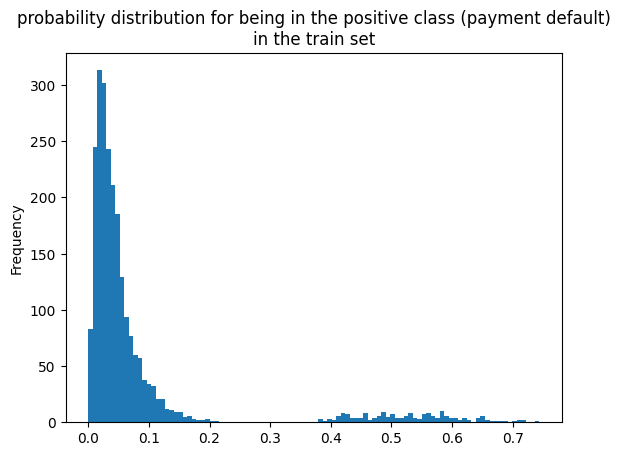

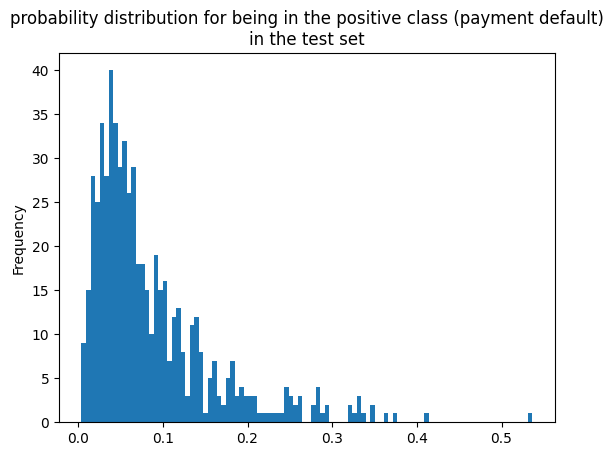

In [109]:
pd.Series(y_pred_train).plot(kind='hist', bins=100, title='probability distribution for being in the positive class (payment default)\nin the train set')
plt.show()

pd.Series(y_pred_test).plot(kind='hist', bins=100, title='probability distribution for being in the positive class (payment default)\nin the test set')
plt.show()

In [93]:
scorer = utils.my_Scorers['loss_of_income']

In [106]:
t, score = scorer.find_best_threshold_and_score(y_train, y_pred_train)

In [107]:
t

0.22

In [108]:
score

0.0

So, in the above distribution, people with a probability above 0.22 will be considered
as possible bad customers. 


## Local and global interpretability

In [9]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(clf)
# shap values explainer with 3 fiels (values, base_values, data)
sv = explainer(X_train_pp)


In [21]:
exp = shap.Explanation(
    sv.values[:,:,1], 
    sv.base_values[:,1], 
    data=X_train_pp.values, 
    feature_names=X_train_pp.columns
)

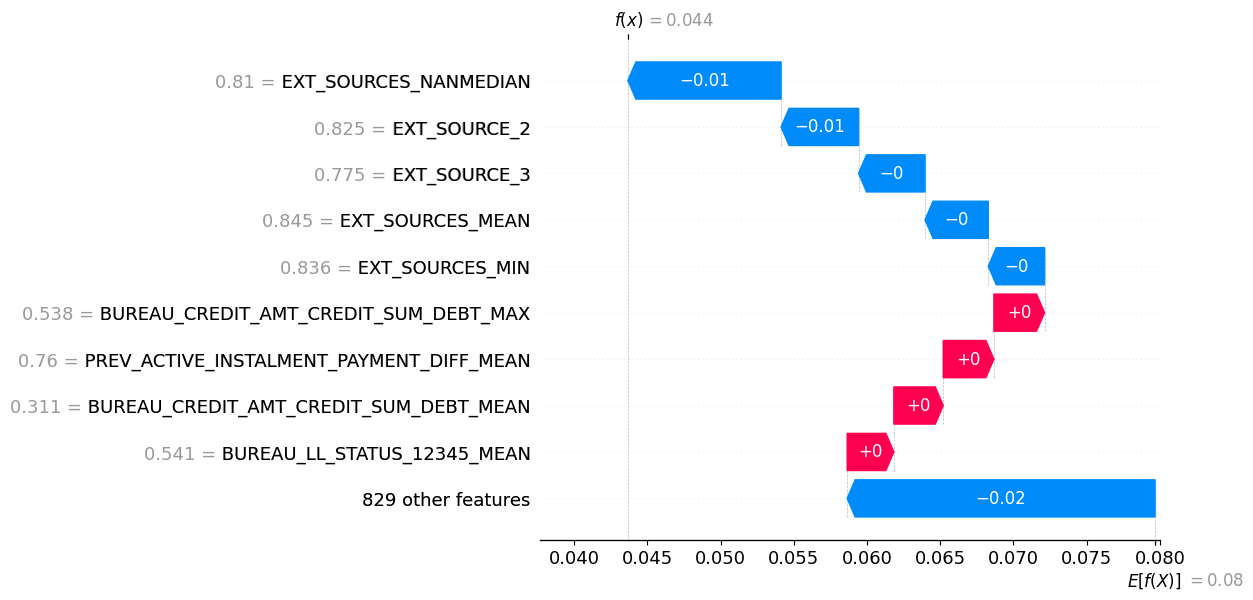

In [32]:
idx = 200
shap.plots.waterfall(exp[idx])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


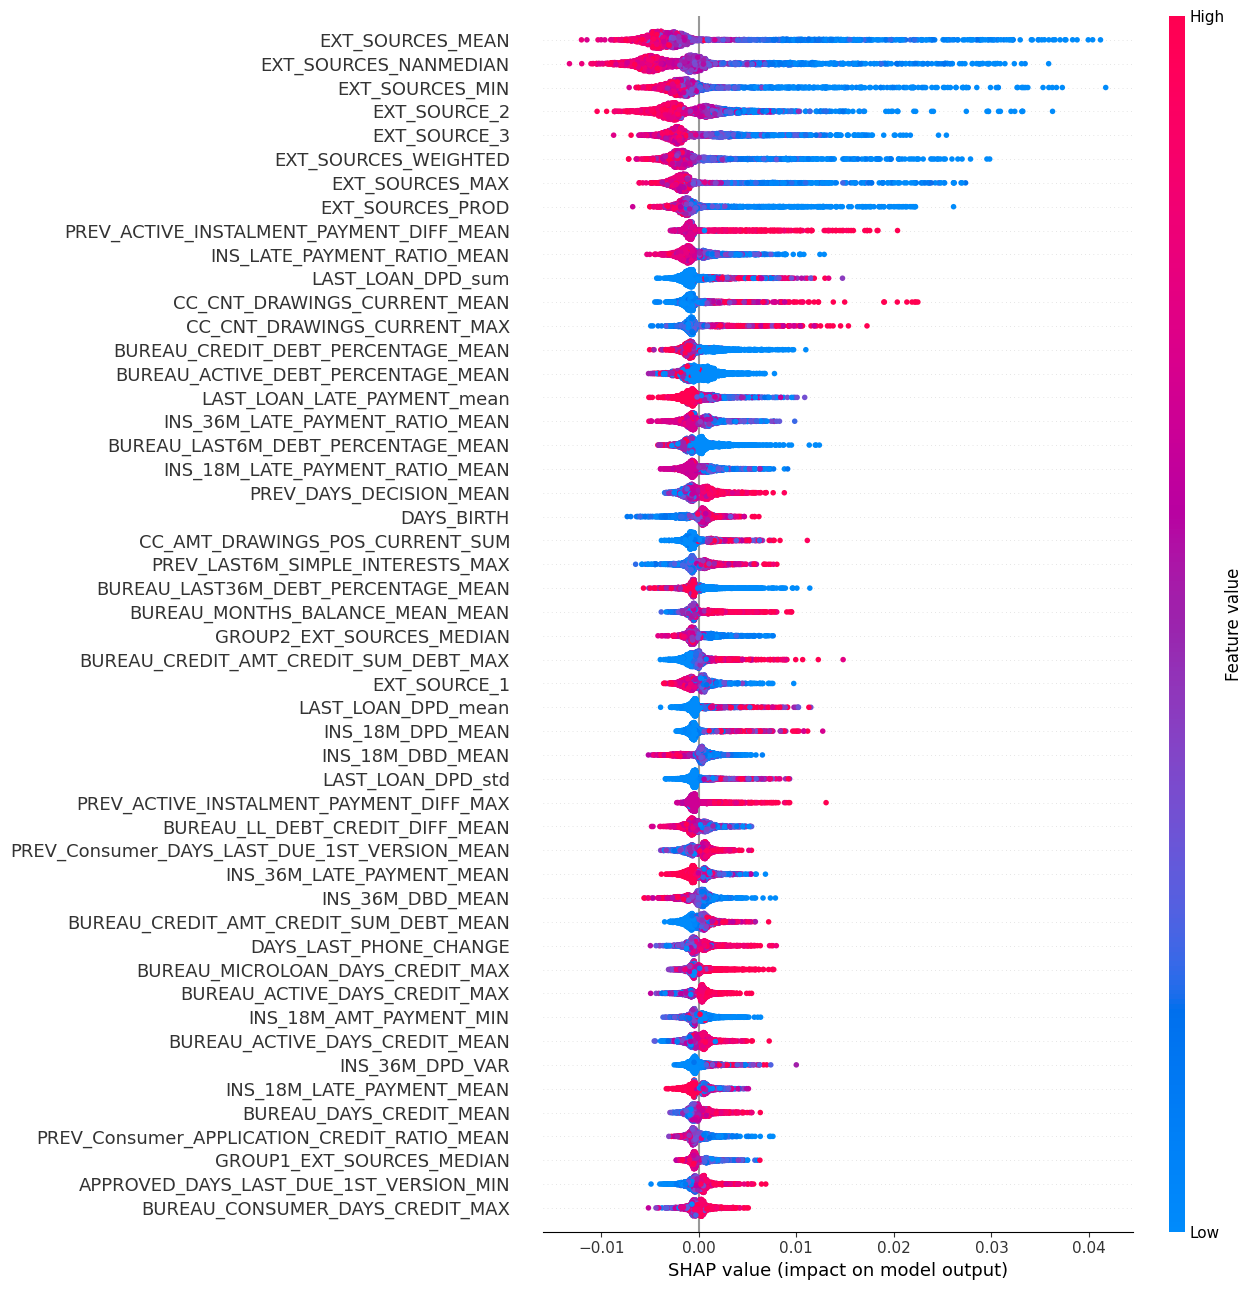

In [74]:
shap.summary_plot(
    exp,
    X_train_pp,
    max_display=50,
    plot_size=(13,13),
)

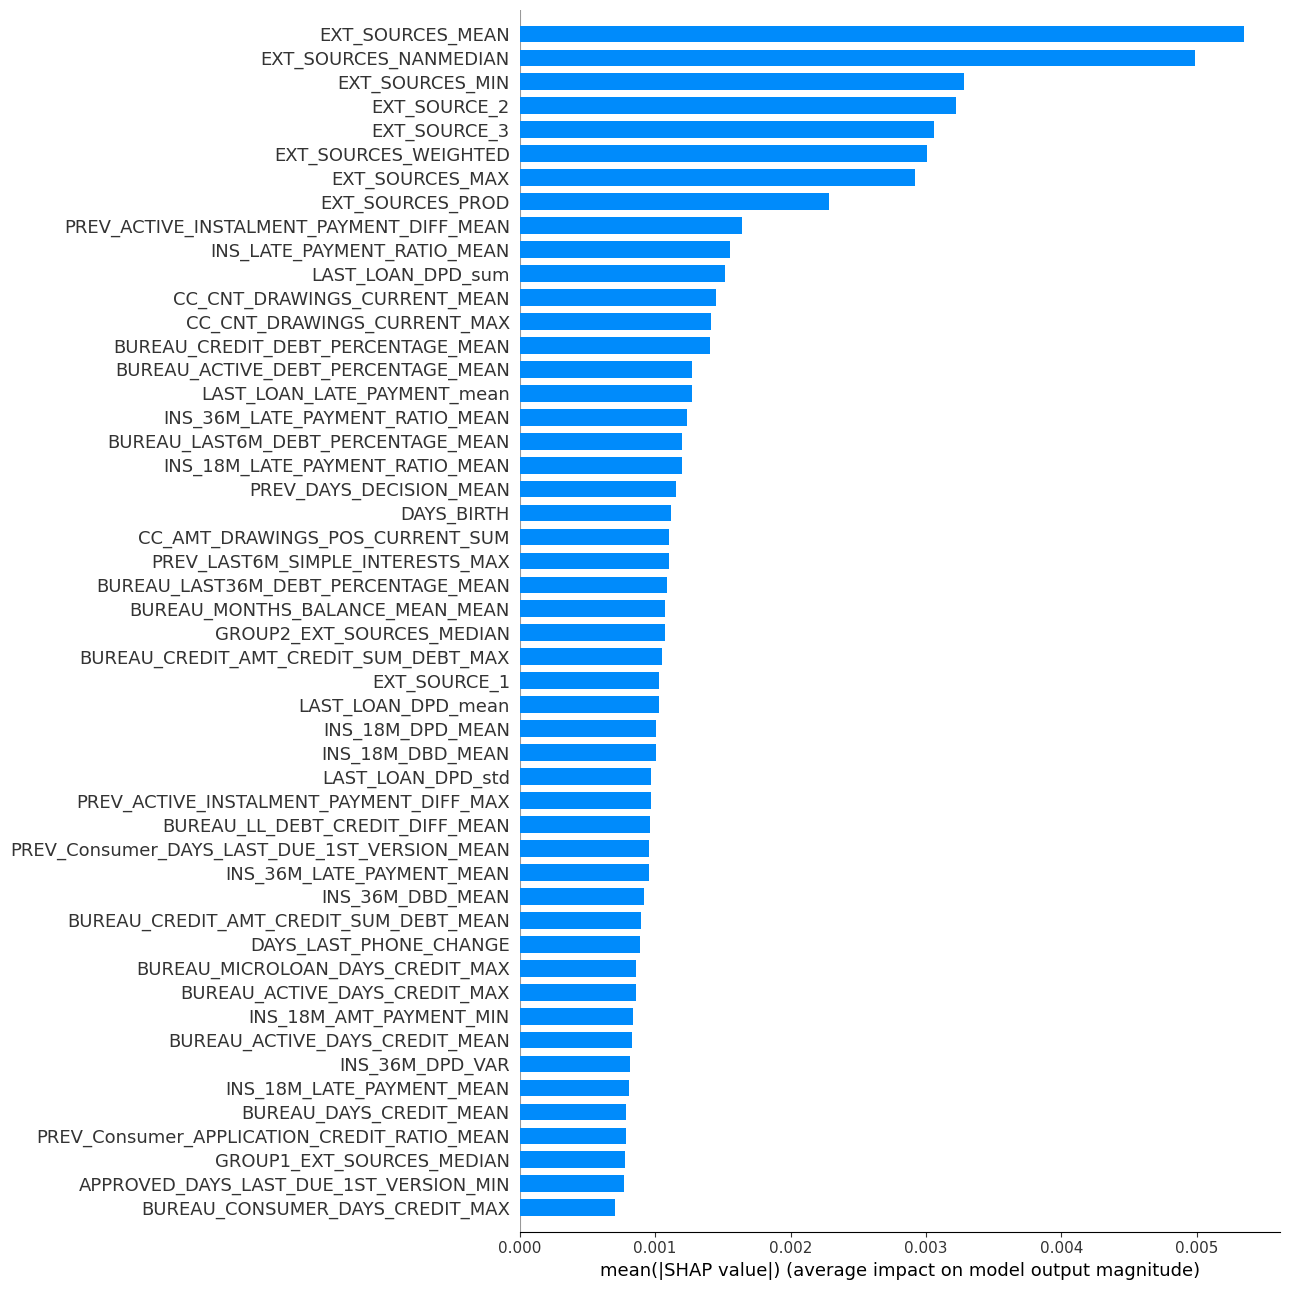

In [30]:
shap.summary_plot(
    exp,
    X_train_pp,
    max_display=50,
    plot_size=(13,13),
    plot_type='bar',
)

In [67]:
shap_values_only1 = sv.values[:, :, 1]
shap_values_only0 = sv.values[:, :, 0]

In [72]:
shap_values_only0[0, :10]

array([ 1.10240162e-05, -7.36966154e-05,  1.31076719e-05,  4.41603040e-04,
       -1.36611417e-04,  1.20250412e-04,  2.21587676e-03,  7.28311979e-04,
        3.45417687e-04, -3.79695742e-04])

In [73]:
shap_values_only1[0, :10]

array([-1.10240162e-05,  7.36966154e-05, -1.31076719e-05, -4.41603040e-04,
        1.36611417e-04, -1.20250412e-04, -2.21587676e-03, -7.28311979e-04,
       -3.45417687e-04,  3.79695742e-04])

In [76]:
np.allclose(shap_values_only0, -shap_values_only1)

True

So the shap values for being in the two classes are opposite.

In [78]:
import numpy as np
vals= np.abs(shap_values_only1).mean(0)
vals.shape

(838,)

In [81]:

feature_importance = pd.DataFrame(list(zip(X_train_pp.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(25)

,col_name,feature_importance_vals
78,EXT_SOURCES_MEAN,0.005348
79,EXT_SOURCES_NANMEDIAN,0.004984
76,EXT_SOURCES_MIN,0.003280
22,EXT_SOURCE_2,0.003225
23,EXT_SOURCE_3,0.003062
75,EXT_SOURCES_WEIGHTED,0.003007
77,EXT_SOURCES_MAX,0.002921
74,EXT_SOURCES_PROD,0.002287
561,PREV_ACTIVE_INSTALMENT_PAYMENT_DIFF_MEAN,0.001642
367,INS_LATE_PAYMENT_RATIO_MEAN,0.001550


# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Tag best runs in experiments.

In [2]:
import mlflow
mlflow.set_tracking_uri('./mlruns')
mlflow.search_experiments()

[<Experiment: artifact_location='file:///home/louberehc/OCR/projets/7_scoring_model/mlruns/128487601886549453', creation_time=1693558352092, experiment_id='128487601886549453', last_update_time=1693558352092, lifecycle_stage='active', name='random_forest_imputation_and_scaling_variation', tags={}>,
 <Experiment: artifact_location='file:///home/louberehc/OCR/projets/7_scoring_model/mlruns/895479541835976974', creation_time=1693469515257, experiment_id='895479541835976974', last_update_time=1693469515257, lifecycle_stage='active', name='random_forest', tags={}>,
 <Experiment: artifact_location='file:///home/louberehc/OCR/projets/7_scoring_model/mlruns/514238879037893566', creation_time=1693228086692, experiment_id='514238879037893566', last_update_time=1693228086692, lifecycle_stage='active', name='test', tags={}>,
 <Experiment: artifact_location='file:///home/louberehc/OCR/projets/7_scoring_model/mlruns/106582075601973595', creation_time=1693061494182, experiment_id='106582075601973595'

In [3]:
exp_names = [
    'random_forest',
    'all_fts_minmax_knn',
    'random_forest_imputation_and_scaling_variation',
]

for exp_name in exp_names:
    utils.add_best_run_tag(exp_name)

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Explore results of scaling and imputation variations

In [53]:
exp_name = 'random_forest_imputation_and_scaling_variation'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, False)

In [63]:
col_sel = [
    'run_id',
    'metrics.CV_AUC',
    'metrics.CV_loss_of_income',
    'metrics.CV_f2',
    'metrics.test_AUC',
    'metrics.test_loss_of_income',
    'metrics.test_f2',
    'fit_time_s',
    # 'scaling_method',
    # 'imputation_method'
]

In [64]:
results.reset_index().groupby(['scaling_method', 'imputation_method']).first()[col_sel]

run_id  \
scaling_method imputation_method                                     
minmax         knn                e97e85079ca642e0acd4952637a66917   
               median             f8ba9086fff94db184f32bfe6b184c46   
               zero               a362235f50774313ac4f7bbd8dd1bda7   
standard       knn                8fbb51ad91614ccfb2d99121a32a6ed6   
               median             4f97e86482f044afb76e784043db0eaa   
               zero               db914d5d20ee48fdad7e46cbf0b1bd20   

                                  metrics.CV_AUC  metrics.CV_loss_of_income  \
scaling_method imputation_method                                              
minmax         knn                      0.751201                   0.278333   
               median                   0.747347                   0.264167   
               zero                     0.732510                   0.258333   
standard       knn                      0.752525                   0.281667   
               median                   0.735382                   0.262500   
               zero                     0.730186                   0.263333   

                                  metrics.CV_f2  metrics.test_AUC  \
scaling_method imputation_method                                    
minmax         knn                     0.523349          0.692729   
               median                  0.525862          0.700870   
               zero                    0.508475          0.695396   
standard       knn                     0.513866          0.677990   
               median                  0.510949          0.697221   
               zero                    0.502793          0.698905   

                                  metrics.test_loss_of_income  \
scaling_method imputation_method                                
minmax         knn                                   0.356667   
               median                                0.333333   
               zero                                  0.353333   
standard       knn                                   0.346667   
               median                                0.340000   
               zero                                  0.310000   

                                  metrics.test_f2  fit_time_s  
scaling_method imputation_method                               
minmax         knn                       0.437158      11.105  
               median                    0.449102      14.661  
               zero                      0.441176    9371.617  
standard       knn                       0.416667      11.271  
               median                    0.443787      15.728  
               zero                      0.448276      12.234

If we would want to maximize AUC, knn is the best. 

To minimize the loss_of_income, minmax + zero imputation give the best results.

This is for the best because it is very much faster to make use of the full dataset we have this way.

# Results for the random forest classifier fine-tuned on the whole dataset

In [4]:
exp_name = 'random_forest_final_model'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=True)

In [21]:
results.head(10)

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
d8af249a9012411199de19d33f40a783,0.698053,0.332687,0.431447,0.704462,0.330400,0.437598,372.307,Random Forest
f35499ce02624c28b2acd8ff480adf7f,0.700987,0.332822,0.435012,0.706140,0.330888,0.439675,386.696,Random Forest
9f987f2d9b424619b7dc6f705b6eecbf,0.699141,0.332874,0.433245,0.706612,0.329459,0.440220,440.540,Random Forest
9a1e10a281b9487eb9464b394ebb0749,0.698443,0.332966,0.431926,0.705587,0.330662,0.439543,383.380,Random Forest
6fd292f3c711484b96ccd92a98a8cac6,0.698533,0.333253,0.432031,0.703220,0.331846,0.438711,401.320,Random Forest
3c000cbaa1274d26a07a5db45d21d995,0.698160,0.333280,0.431785,0.702512,0.330958,0.437730,389.926,Random Forest
ed2fbef4ee7140a18e8bb3da493efe91,0.700763,0.333397,0.434569,0.705939,0.330313,0.439472,394.353,Random Forest
e502c30a74cd4769adeff305b8461290,0.699308,0.333423,0.433604,0.706363,0.330104,0.440065,555.452,Random Forest
13fcb093c325471c835cf069189df7af,0.698360,0.333484,0.431792,0.705953,0.330139,0.439510,443.708,Random Forest


Here, the AUC score is quite deteriorated and the loss_of_income is not as good as it was when we trained model on a little subset. This forces me to verify scores for example with an other model which performed well such as lightgbm.

# Results for lightgbm

In [3]:
exp_name = 'lightgbm'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=True)

In [5]:
results.head()

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
b28c67e1b2e44dc58afdd82fcc002e5f,0.721945,0.314635,0.460757,0.727502,0.311861,0.466639,2005.550,LightGBM Classifier
0457b332d564420e8f97d0b763e15ccd,0.672188,0.360227,0.401189,0.682462,0.355875,0.413079,267.013,LightGBM Classifier
adea790dc21b4d90bf0233ff3160d78d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LightGBM Classifier
fc6719acfb634b6580e3fe6375ca72cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
87d885da9ab843cfb944c1ae2f2f15c6,NaN,NaN,NaN,NaN,NaN,NaN,234.722,LightGBM Classifier


After 2 runs, I already see something more interesting. Let's run 10 more models and pick the best, and stop here for this project.